In [33]:
import os
import json
import pandas as pd
import numpy as np
from autogluon.tabular import TabularPredictor
from pykrige.ok import OrdinaryKriging
from sklearn.metrics import r2_score
from pyproj import Transformer
from tqdm import tqdm
import pickle

In [34]:
# 获取当前日期
def get_dtime():
    # 例如20240516
    import datetime
    dtime = datetime.datetime.now().strftime('%Y%m%d')
    return dtime

In [35]:
# 导入autogluon模型
model_path = r"F:\cache_data\zone_ana\dy\modle\autogluon_type_class_DY"

In [36]:
# 砂岩
sy_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'sy'),'sdt'))
sy_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'sy'),'fzrt'))
sy_zrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'sy'),'zrt'))
# 碳酸岩
tsy_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'tsy'),'sdt'))
tsy_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'tsy'),'fzrt'))
tsy_zrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'tsy'),'zrt'))
# 第四系红粘土
hnt_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'hnt'),'sdt'))
hnt_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'hnt'),'fzrt'))
hnt_zrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'hnt'),'zrt'))
# 泥页岩
nyy_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'nyy'),'sdt'))
nyy_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'nyy'),'fzrt'))
nyy_zrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'nyy'),'zrt'))
# 紫红色砂页岩
zhsyy_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'zhsyy'),'sdt'))
zhsyy_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'zhsyy'),'fzrt'))
zhsyy_zrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'zhsyy'),'zrt'))
# 河流冲积物
hlcjw_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'hlcjw'),'sdt'))
# 砾岩
ly_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'ly'),'sdt'))
ly_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'ly'),'fzrt'))
ly_zrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'ly'),'zrt'))
# 第四纪冰川冲积物
bccjw_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'bccjw'),'sdt'))
bccjw_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'bccjw'),'fzrt'))
bccjw_zrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'bccjw'),'zrt'))
# 砂页岩
syy_sdt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'syy'),'sdt'))
syy_fzrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'syy'),'fzrt'))
syy_zrt_predictor = TabularPredictor.load(os.path.join(os.path.join(model_path,'syy'),'zrt'))

In [37]:
# 获取特征函数

def get_feature_names(predictor):
    feature_names = predictor.feature_metadata_in.get_features()
    return feature_names
sdt_feature_names = syy_sdt_predictor.feature_metadata_in.get_features()
print("SDT",sdt_feature_names)
fzrt_feature_names = syy_fzrt_predictor.feature_metadata_in.get_features()
print("FZRT",fzrt_feature_names)
zrt_feature_names = syy_zrt_predictor.feature_metadata_in.get_features()
print("ZRT",zrt_feature_names)

SDT ['Centroid_X', 'Centroid_Y', 'DEM_MAX', 'DEM_MIN', 'DEM_MEAN', 'DEM_RANGE', 'DEM_STD', 'ndvi_MEAN', 'PCA_0_MEAN', 'Slope_MAX', 'Slope_MIN', 'Slope_MEAN', 'Slope_RANGE', 'Aspect_MEAN', 'MRVBF_MAX', 'MRVBF_MIN', 'MRVBF_MEAN', 'MRVBF_RANGE', 'TopographicWetnessIndex_MEAN', 'TopographicWetnessIndex_RANGE', 'Mean_MEAN', 'PH_MEAN', 'PRE_MEAN', 'PRE_RANGE', 'SRA_MEAN', 'SRA_RANGE', 'TMP_MEAN', 'TMP_RANGE', 'VAP_MEAN', 'VAP_RANGE', 'WIND_MEAN', 'WIND_RANGE', 'PlanCurvature_MEAN', 'PlanCurvature_RANGE']
FZRT ['DLMC', 'Centroid_X', 'Centroid_Y', 'DEM_MAX', 'DEM_MIN', 'DEM_MEAN', 'DEM_RANGE', 'DEM_STD', 'ndvi_MEAN', 'PCA_0_MEAN', 'Slope_MAX', 'Slope_MIN', 'Slope_MEAN', 'Slope_RANGE', 'Aspect_MEAN', 'MRVBF_MAX', 'MRVBF_MIN', 'MRVBF_MEAN', 'MRVBF_RANGE', 'TopographicWetnessIndex_MEAN', 'TopographicWetnessIndex_RANGE', 'Mean_MEAN', 'PH_MEAN', 'PRE_MEAN', 'PRE_RANGE', 'SRA_MEAN', 'SRA_RANGE', 'TMP_MEAN', 'TMP_RANGE', 'VAP_MEAN', 'VAP_RANGE', 'WIND_MEAN', 'WIND_RANGE', 'PlanCurvature_MEAN', 'PlanC

In [38]:
# 存放预测结果的路径
result_path =  r"F:\cache_data\zone_ana\dy\prediction_result"

In [39]:
# 读取数据集
feature_path = r'F:\cache_data\zone_ana\dy\prediction_data\result_20240619.csv'

In [40]:
feature_df = pd.read_csv(feature_path)

In [41]:
feature_df.columns

Index(['OBJECTID', 'DLMC', '母质', 'XMin', 'YMin', 'XMax', 'YMax', 'Centroid_X',
       'Centroid_Y', 'DEM_COUNT',
       ...
       'PlanCurvature_COUNT', 'PlanCurvature_AREA', 'PlanCurvature_MIN',
       'PlanCurvature_MAX', 'PlanCurvature_RANGE', 'PlanCurvature_MEAN',
       'PlanCurvature_STD', 'PlanCurvature_SUM', 'PlanCurvature_MEDIAN',
       'PlanCurvature_PCT90'],
      dtype='object', length=159)

In [42]:
rows_with_nan = feature_df.loc[feature_df.isnull().any(axis=1)]
rows_with_nan

,OBJECTID,DLMC,母质,XMin,YMin,XMax,YMax,Centroid_X,Centroid_Y,DEM_COUNT,...,PlanCurvature_COUNT,PlanCurvature_AREA,PlanCurvature_MIN,PlanCurvature_MAX,PlanCurvature_RANGE,PlanCurvature_MEAN,PlanCurvature_STD,PlanCurvature_SUM,PlanCurvature_MEDIAN,PlanCurvature_PCT90


In [43]:
# 选择数值类型的列
numeric_cols = feature_df.select_dtypes(include=[np.float64])

# 计算数值列的均值
mean_values = numeric_cols.mean()

# 用均值填充数值列的空值
feature_df[numeric_cols.columns] = numeric_cols.fillna(mean_values)

In [44]:
rows_with_nan = feature_df.loc[feature_df.isnull().any(axis=1)]
rows_with_nan

,OBJECTID,DLMC,母质,XMin,YMin,XMax,YMax,Centroid_X,Centroid_Y,DEM_COUNT,...,PlanCurvature_COUNT,PlanCurvature_AREA,PlanCurvature_MIN,PlanCurvature_MAX,PlanCurvature_RANGE,PlanCurvature_MEAN,PlanCurvature_STD,PlanCurvature_SUM,PlanCurvature_MEDIAN,PlanCurvature_PCT90


In [45]:
feature_df.rename(columns={'母质':'MZ'},inplace=True)

In [46]:
dataset = feature_df

In [47]:
dataset.columns

Index(['OBJECTID', 'DLMC', 'MZ', 'XMin', 'YMin', 'XMax', 'YMax', 'Centroid_X',
       'Centroid_Y', 'DEM_COUNT',
       ...
       'PlanCurvature_COUNT', 'PlanCurvature_AREA', 'PlanCurvature_MIN',
       'PlanCurvature_MAX', 'PlanCurvature_RANGE', 'PlanCurvature_MEAN',
       'PlanCurvature_STD', 'PlanCurvature_SUM', 'PlanCurvature_MEDIAN',
       'PlanCurvature_PCT90'],
      dtype='object', length=159)

In [48]:

duplicated_rows = dataset[dataset['OBJECTID'].duplicated(keep=False)]

In [49]:
duplicated_rows

,OBJECTID,DLMC,MZ,XMin,YMin,XMax,YMax,Centroid_X,Centroid_Y,DEM_COUNT,...,PlanCurvature_COUNT,PlanCurvature_AREA,PlanCurvature_MIN,PlanCurvature_MAX,PlanCurvature_RANGE,PlanCurvature_MEAN,PlanCurvature_STD,PlanCurvature_SUM,PlanCurvature_MEDIAN,PlanCurvature_PCT90


In [57]:
# 统计总数据中各个岩石类型的总数
value_counts_dict = dataset['MZ'].value_counts().to_dict()


In [59]:
# 筛选砂岩水稻土数据
sy_sdt_data = dataset[dataset['DLMC'].isin(['水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                      & (dataset['MZ'] == '砂岩')]
# 筛砂岩选非自然土数据
sy_fzrt_data = dataset[~dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地','水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                       & (dataset['MZ'] == '砂岩')]
# 筛选自然土数据
sy_zrt_data = dataset[dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地'])
                   & (dataset['MZ'] == '砂岩')]
print(sy_sdt_data.shape[0]+sy_fzrt_data.shape[0]+sy_zrt_data.shape[0],value_counts_dict['砂岩'])

35158 35158


In [61]:
# 筛选碳酸岩水稻土数据
tsy_sdt_data = dataset[dataset['DLMC'].isin(['水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                      & (dataset['MZ'] == '碳酸岩')]

# 筛选碳酸岩选非自然土数据
tsy_fzrt_data = dataset[~dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地','水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                        &(dataset['MZ'] == '碳酸岩')]

# 筛选碳酸岩自然土数据
tsy_zrt_data = dataset[dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地'])
                   & (dataset['MZ'] == '碳酸岩')]
print(tsy_sdt_data.shape[0]+tsy_fzrt_data.shape[0]+tsy_zrt_data.shape[0],value_counts_dict['碳酸岩'])

49993 49993


In [62]:
# 筛选第四系红粘土水稻土数据
hnt_sdt_data = dataset[dataset['DLMC'].isin(['水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                      & (dataset['MZ'] == '第四系红粘土')]

# 筛选第四系红粘土非自然土数据
hnt_fzrt_data = dataset[~dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地','水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                       & (dataset['MZ'] == '第四系红粘土')]

# 筛选第四系红粘土自然土数据
hnt_zrt_data = dataset[dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地'])
                   & (dataset['MZ'] == '第四系红粘土')]
print(hnt_sdt_data.shape[0]+hnt_fzrt_data.shape[0]+hnt_zrt_data.shape[0],value_counts_dict['第四系红粘土'])

22985 22985


In [63]:
# 筛选泥(页)岩水稻土数据
nyy_sdt_data = dataset[dataset['DLMC'].isin(['水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                      & (dataset['MZ'] == '泥(页)岩')]

# 筛选泥(页)岩非自然土数据
nyy_fzrt_data = dataset[~dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地','水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                       & (dataset['MZ'] == '泥(页)岩')]

# 筛选泥(页)岩自然土数据
nyy_zrt_data = dataset[dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地'])
                   & (dataset['MZ'] == '泥(页)岩')]
print(nyy_sdt_data.shape[0]+nyy_fzrt_data.shape[0]+nyy_zrt_data.shape[0],value_counts_dict['泥(页)岩'])

32962 32962


In [64]:
# 筛选紫红色砂页岩水稻土数据
zhsyy_sdt_data = dataset[dataset['DLMC'].isin(['水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                      &(dataset['MZ'] == '紫红色砂页岩')]

# 筛选紫红色砂页岩非自然土数据
zhsyy_fzrt_data = dataset[~dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地','水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                       & (dataset['MZ'] == '紫红色砂页岩')]

# 筛选紫红色砂页岩自然土数据
zhsyy_zrt_data = dataset[dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地'])
                   & (dataset['MZ'] == '紫红色砂页岩')]
print(zhsyy_sdt_data.shape[0]+zhsyy_fzrt_data.shape[0]+zhsyy_zrt_data.shape[0],value_counts_dict['紫红色砂页岩'])

178 178


In [67]:
# 筛选河流冲积物水稻土数据
hlcjw_sdt_data = dataset[(dataset['MZ'] == '河流冲积物')]
print(hlcjw_sdt_data.shape[0],value_counts_dict['河流冲积物'])

4749 4749


In [73]:
# 筛选砾岩水稻土数据
ly_sdt_data = dataset[dataset['DLMC'].isin(['水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                      & (dataset['MZ'] == '砾岩')]

# 筛选砾岩非自然土数据
ly_fzrt_data = dataset[~dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地','水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                       & (dataset['MZ'] == '砾岩')]

# 筛选砾岩非自然土数据
ly_zrt_data = dataset[dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地']) 
                       & (dataset['MZ'] == '砾岩')]
print(ly_sdt_data.shape[0]+ly_fzrt_data.shape[0]+ly_zrt_data.shape[0],value_counts_dict['砾岩'])

754 754


In [74]:
# 筛选第四纪冰川冲积物水稻土数据
bccjw_sdt_data = dataset[dataset['DLMC'].isin(['水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                     & (dataset['MZ'] == '第四纪冰川冲积物')]

# 筛选第四纪冰川冲积物非自然土数据
bccjw_fzrt_data = dataset[~dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地','水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                       & (dataset['MZ'] == '第四纪冰川冲积物')]

# 筛选第四纪冰川冲积物自然土数据
bccjw_zrt_data = dataset[dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地'])
                   & (dataset['MZ'] == '第四纪冰川冲积物')]
print(bccjw_sdt_data.shape[0]+bccjw_fzrt_data.shape[0]+bccjw_zrt_data.shape[0],value_counts_dict['第四纪冰川冲积物'])

131 131


In [75]:
# 筛选砂页岩水稻土数据
syy_sdt_data = dataset[dataset['DLMC'].isin(['水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                      & (dataset['MZ'] == '砂页岩')]

# 筛选砂页岩非自然土数据
syy_fzrt_data = dataset[~dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地','水田','水浇地','坑塘水面','养殖坑塘','内陆滩涂']) 
                       & (dataset['MZ'] == '砂页岩')]

# 筛选砂页岩物自然土数据
syy_zrt_data = dataset[dataset['DLMC'].isin(['乔木林地','灌木林地','竹林地','其他林地','其他草地','天然牧草地','人工牧草地'])
                   & (dataset['MZ'] == '砂页岩')]
print(syy_sdt_data.shape[0]+syy_fzrt_data.shape[0]+syy_zrt_data.shape[0],value_counts_dict['砂页岩'])

366 366


In [76]:
# 查看各个数据集的大小
print('砂岩',sy_sdt_data.shape,sy_fzrt_data.shape,sy_zrt_data.shape)
print('碳酸岩',tsy_sdt_data.shape,tsy_fzrt_data.shape,tsy_zrt_data.shape)
print('第四系红粘土',hnt_sdt_data.shape,hnt_fzrt_data.shape,hnt_zrt_data.shape)
print('泥页岩',nyy_sdt_data.shape,nyy_fzrt_data.shape,nyy_zrt_data.shape)
print('紫红色砂页岩',zhsyy_sdt_data.shape,zhsyy_fzrt_data.shape,zhsyy_zrt_data.shape)
print('河流冲积物',hlcjw_sdt_data.shape)
print('砾岩',ly_sdt_data.shape,ly_fzrt_data.shape,ly_zrt_data.shape)
print('第四纪冰川冲积物',bccjw_sdt_data.shape,bccjw_fzrt_data.shape,bccjw_zrt_data.shape)
print('砂页岩',syy_sdt_data.shape,syy_fzrt_data.shape,syy_zrt_data.shape)



砂岩 (6716, 159) (12964, 159) (15478, 159)
碳酸岩 (7055, 159) (20838, 159) (22100, 159)
第四系红粘土 (3194, 159) (10729, 159) (9062, 159)
泥页岩 (5839, 159) (14127, 159) (12996, 159)
紫红色砂页岩 (18, 159) (80, 159) (80, 159)
河流冲积物 (4749, 159)
砾岩 (44, 159) (352, 159) (358, 159)
第四纪冰川冲积物 (5, 159) (58, 159) (68, 159)
砂页岩 (23, 159) (215, 159) (128, 159)


In [77]:
# 获取对照字典
with open(r'D:\worker_code\Terrain_Test\data\soil_dict_20240619.json', 'r') as f:
    soil_dict = json.load(f)
# 将键转为int
soil_dict = {int(k):v for k, v in soil_dict.items()}

In [78]:
# 模型选择
select_model = 'WeightedEnsemble_L2'
# sdt_model = 'WeightedEnsemble_L2'

In [80]:
# 概率预测函数
def predict_top_classes(data, predictor,feature_names, model, top_n, soil_dict):
    """
    根据给定的AutoGluon模型，预测数据集中的前n个最可能的类别及其概率，并根据提供的字典转换类别编号为描述字符串。
    参数:
    data (DataFrame): 输入的数据集。
    predictor（model）: 对应的模型
    feature_names (list): 用于预测的特征名列表。
    model (str): 选择的模型名称。
    top_n (int): 需要返回的最高概率的类别数量。
    soil_dict (dict): 类别编号到描述字符串的映射字典。
    
    返回:
    DataFrame: 原始数据与预测结果合并后的DataFrame。
    """
    # 复制数据
    data = data.copy()
    # 预测概率
    pred_probs = predictor.predict_proba(data[feature_names], model=model)
    # 获取概率最高的前n个类别及其概率
    top_classes = pred_probs.apply(lambda x: pd.Series(x.nlargest(top_n).index.astype(int).tolist() + x.nlargest(top_n).values.tolist()), axis=1)
    # 重命名列
    class_cols = ['Class{}'.format(i+1) for i in range(top_n)]
    prob_cols = ['Prob{}'.format(i+1) for i in range(top_n)]
    top_classes.columns = class_cols + prob_cols
    # 转换类别编号为描述字符串
    for col in class_cols:
        top_classes[col] = top_classes[col].map(soil_dict)
    # 计算每个预测的熵
    entropy = pred_probs.apply(lambda x: -np.sum(x * np.log(x + 1e-9)), axis=1)
    top_classes['Entropy'] = entropy
    # 计算每个预测的不确定性（标准差）
    uncertainty = pred_probs.std(axis=1)
    top_classes['Uncertainty'] = uncertainty
    # 将新列添加到原有的DataFrame中
    return pd.concat([data, top_classes], axis=1)

In [81]:
# 模型预测
sy_sdt_result_df = predict_top_classes(sy_sdt_data, sy_sdt_predictor,get_feature_names(sy_sdt_predictor), select_model, 2, soil_dict)
sy_fzrt_result_df = predict_top_classes(sy_fzrt_data, sy_fzrt_predictor,get_feature_names(sy_fzrt_predictor), select_model, 2, soil_dict)
sy_zrt_result_df = predict_top_classes(sy_zrt_data, sy_zrt_predictor,get_feature_names(sy_zrt_predictor), select_model, 2, soil_dict)

tsy_sdt_result_df = predict_top_classes(tsy_sdt_data, tsy_sdt_predictor,get_feature_names(tsy_sdt_predictor), select_model, 2, soil_dict)
tsy_fzrt_result_df = predict_top_classes(tsy_fzrt_data, tsy_fzrt_predictor,get_feature_names(tsy_fzrt_predictor), select_model, 2, soil_dict)
tsy_zrt_result_df = predict_top_classes(tsy_zrt_data, tsy_zrt_predictor,get_feature_names(tsy_zrt_predictor), select_model, 2, soil_dict)

hnt_sdt_result_df = predict_top_classes(hnt_sdt_data, hnt_sdt_predictor,get_feature_names(hnt_sdt_predictor), select_model, 2, soil_dict)
hnt_fzrt_result_df = predict_top_classes(hnt_fzrt_data, hnt_fzrt_predictor,get_feature_names(hnt_fzrt_predictor), select_model, 2, soil_dict)
hnt_zrt_result_df = predict_top_classes(hnt_zrt_data, hnt_zrt_predictor,get_feature_names(hnt_zrt_predictor), select_model, 2, soil_dict)

nyy_sdt_result_df = predict_top_classes(nyy_sdt_data, nyy_sdt_predictor,get_feature_names(nyy_sdt_predictor), select_model, 2, soil_dict)
nyy_fzrt_result_df = predict_top_classes(nyy_fzrt_data, nyy_fzrt_predictor,get_feature_names(nyy_fzrt_predictor), select_model, 2, soil_dict)
nyy_zrt_result_df = predict_top_classes(nyy_zrt_data, nyy_zrt_predictor,get_feature_names(nyy_zrt_predictor), select_model, 2, soil_dict)

zhsyy_sdt_result_df = predict_top_classes(zhsyy_sdt_data, zhsyy_sdt_predictor,get_feature_names(zhsyy_sdt_predictor), select_model, 2, soil_dict)
zhsyy_fzrt_result_df = predict_top_classes(zhsyy_fzrt_data, zhsyy_fzrt_predictor,get_feature_names(zhsyy_fzrt_predictor), select_model, 2, soil_dict)
zhsyy_zrt_result_df = predict_top_classes(zhsyy_zrt_data, zhsyy_zrt_predictor,get_feature_names(zhsyy_zrt_predictor), select_model, 2, soil_dict)

hlcjw_sdt_result_df = predict_top_classes(hlcjw_sdt_data, hlcjw_sdt_predictor,get_feature_names(hlcjw_sdt_predictor), select_model, 2, soil_dict)


ly_sdt_result_df = predict_top_classes(ly_sdt_data, ly_sdt_predictor,get_feature_names(ly_sdt_predictor), select_model, 2, soil_dict)
ly_fzrt_result_df = predict_top_classes(ly_fzrt_data, ly_fzrt_predictor,get_feature_names(ly_fzrt_predictor), select_model, 2, soil_dict)
ly_zrt_result_df = predict_top_classes(ly_zrt_data, ly_zrt_predictor,get_feature_names(ly_zrt_predictor), select_model, 2, soil_dict)

bccjw_sdt_result_df = predict_top_classes(bccjw_sdt_data, bccjw_sdt_predictor,get_feature_names(bccjw_sdt_predictor), select_model, 2, soil_dict)
bccjw_fzrt_result_df = predict_top_classes(bccjw_fzrt_data, bccjw_fzrt_predictor,get_feature_names(bccjw_fzrt_predictor), select_model, 2, soil_dict)
bccjw_zrt_result_df = predict_top_classes(bccjw_zrt_data, bccjw_zrt_predictor,get_feature_names(bccjw_zrt_predictor), select_model, 2, soil_dict)

syy_sdt_result_df = predict_top_classes(syy_sdt_data, syy_sdt_predictor,get_feature_names(syy_sdt_predictor), select_model, 2, soil_dict)
syy_fzrt_result_df = predict_top_classes(syy_fzrt_data, syy_fzrt_predictor,get_feature_names(syy_fzrt_predictor), select_model, 2, soil_dict)
syy_zrt_result_df = predict_top_classes(syy_zrt_data, syy_zrt_predictor,get_feature_names(syy_zrt_predictor), select_model, 2, soil_dict)

In [82]:
# 将所有的DataFrame放入一个列表中
dfs = [
    sy_sdt_result_df, sy_fzrt_result_df, sy_zrt_result_df,
    tsy_sdt_result_df, tsy_fzrt_result_df, tsy_zrt_result_df,
    hnt_sdt_result_df, hnt_fzrt_result_df, hnt_zrt_result_df,
    nyy_sdt_result_df, nyy_fzrt_result_df, nyy_zrt_result_df,
    zhsyy_sdt_result_df, zhsyy_fzrt_result_df, zhsyy_zrt_result_df,
    hlcjw_sdt_result_df,
    ly_sdt_result_df, ly_fzrt_result_df, ly_zrt_result_df,
    bccjw_sdt_result_df, bccjw_fzrt_result_df, bccjw_zrt_result_df,
    syy_sdt_result_df, syy_fzrt_result_df, syy_zrt_result_df
]

# 使用pd.concat合并所有的DataFrame
result_df = pd.concat(dfs, ignore_index=True)


In [84]:
result_df.columns

Index(['OBJECTID', 'DLMC', 'MZ', 'XMin', 'YMin', 'XMax', 'YMax', 'Centroid_X',
       'Centroid_Y', 'DEM_COUNT',
       ...
       'PlanCurvature_STD', 'PlanCurvature_SUM', 'PlanCurvature_MEDIAN',
       'PlanCurvature_PCT90', 'Class1', 'Class2', 'Prob1', 'Prob2', 'Entropy',
       'Uncertainty'],
      dtype='object', length=165)

In [85]:
# 获取指定列
result_df = result_df[['OBJECTID','Class1', 'Class2', 'Prob1','Prob2', 'Entropy', 'Uncertainty']]

In [86]:
# 获取三普土种对照字典
# 读取Excel文件
sp_file_path = r"C:\Users\Runker\Desktop\search_dict3.xlsx"
df = pd.read_excel(sp_file_path)

# 使用前向填充（ffill）处理合并单元格的情况
df_filled = df.ffill()
# 定义一个函数来为每一行生成一个字典
def create_dict(row):
    return {
        row['TZ']: {
            '土类': row['TL'],
            '亚类': row['YL'],
            '土属': row['TS'],
        }
    }

# 使用apply方法为每一行应用这个函数，并将结果合并到一个字典中
sp_soiltype_dict = {}
for d in df_filled.apply(create_dict, axis=1):
    sp_soiltype_dict.update(d)

In [87]:
sp_soiltype_dict

{'黄红泥田': {'土类': '水稻土', '亚类': '潴育型水稻土', '土属': '红泥田'},
 '潮泥田': {'土类': '水稻土', '亚类': '潴育型水稻土', '土属': '潮泥田'},
 '黄白粉泥田': {'土类': '水稻土', '亚类': '潜育型水稻土', '土属': '青白粉泥田'},
 '石灰泥田': {'土类': '水稻土', '亚类': '潴育型水稻土', '土属': '石灰泥田'},
 '黄浅鳝泥田': {'土类': '水稻土', '亚类': '淹育型水稻土', '土属': '浅鳝泥田'},
 '青石灰泥田': {'土类': '水稻土', '亚类': '潜育型水稻土', '土属': '青灰泥田'},
 '浅石灰泥田': {'土类': '水稻土', '亚类': '淹育型水稻土', '土属': '浅灰泥田'},
 '黄青白粉泥田': {'土类': '水稻土', '亚类': '潜育型水稻土', '土属': '青白粉泥田'},
 '黄青砂泥田': {'土类': '水稻土', '亚类': '潜育型水稻土', '土属': '青砂泥田'},
 '黄浅白粉泥田': {'土类': '水稻土', '亚类': '淹育型水稻土', '土属': '浅白粉泥田'},
 '黄浅红泥田': {'土类': '水稻土', '亚类': '淹育型水稻土', '土属': '浅红泥田'},
 '中层灰泥质黄色石灰土': {'土类': '石灰土', '亚类': '黄色石灰土', '土属': '灰泥质黄色石灰土'},
 '薄层灰泥质黄色石灰土': {'土类': '石灰土', '亚类': '黄色石灰土', '土属': '灰泥质黄色石灰土'},
 '中层壤质黄色石灰土': {'土类': '石灰土', '亚类': '黄色石灰土', '土属': '壤质黄色石灰土'},
 '薄层硅质黄壤': {'土类': '黄壤', '亚类': '典型黄壤', '土属': '硅质黄壤'},
 '薄层砾硅质黄壤': {'土类': '黄壤', '亚类': '典型黄壤', '土属': '砾硅质黄壤'},
 '中层砾壤质黑色石灰土': {'土类': '石灰土', '亚类': '黑色石灰土', '土属': '砾壤质黑色石灰土'},
 '薄层砾壤质黑色石灰土': {'土类': '石灰土', '亚类': '黑色

In [88]:
# 使用 apply 方法结合 lambda 函数来获取对应的 '土类' 值
result_df = result_df.copy()
result_df['Class1_tl'] = result_df['Class1'].apply(lambda x: sp_soiltype_dict.get(x, {}).get('土类', None))
result_df['Class1_yl'] = result_df['Class1'].apply(lambda x: sp_soiltype_dict.get(x, {}).get('亚类', None))
result_df['Class1_ts'] = result_df['Class1'].apply(lambda x: sp_soiltype_dict.get(x, {}).get('土属', None))


In [89]:
result_df

,OBJECTID,Class1,Class2,Prob1,Prob2,Entropy,Uncertainty,Class1_tl,Class1_yl,Class1_ts
0,6,黄浅白粉泥田,黄青白粉泥田,0.999934,0.000033,0.000771,0.447177,水稻土,淹育型水稻土,浅白粉泥田
1,9,黄浅白粉泥田,黄青白粉泥田,0.998829,0.000428,0.010350,0.446559,水稻土,淹育型水稻土,浅白粉泥田
2,10,黄浅白粉泥田,黄青白粉泥田,0.997560,0.001167,0.019665,0.445850,水稻土,淹育型水稻土,浅白粉泥田
3,12,黄浅白粉泥田,黄青白粉泥田,0.998348,0.000633,0.014038,0.446290,水稻土,淹育型水稻土,浅白粉泥田
4,13,黄浅白粉泥田,黄青白粉泥田,0.998297,0.000707,0.014401,0.446262,水稻土,淹育型水稻土,浅白粉泥田
...,...,...,...,...,...,...,...,...,...,...
147271,126122,腐薄层砂泥质黄壤,腐厚层砂泥质黄壤,0.376667,0.333333,1.092963,0.043333,黄壤,典型黄壤,砂泥质黄壤
147272,126164,腐薄层砂泥质黄壤,腐中层砂泥质黄壤,0.506667,0.286667,1.028496,0.155349,黄壤,典型黄壤,砂泥质黄壤
147273,138932,腐中层砂泥质黄壤,腐薄层砂泥质黄壤,0.410000,0.390000,1.054670,0.115902,黄壤,典型黄壤,砂泥质黄壤
147274,138934,腐薄层砂泥质黄壤,腐中层砂泥质黄壤,0.410000,0.366667,1.068229,0.097696,黄壤,典型黄壤,砂泥质黄壤


In [92]:
# 保存数据
result_df.to_csv(os.path.join(result_path, f'prediction_class_{select_model}_{get_dtime()}.csv'),index=False)

In [91]:
pd.DataFrame(result_df['Class1'].value_counts()),len(list(result_df['Class1'].value_counts())),len(result_df['Class1_ts'].value_counts())

(            count
 Class1           
 薄层灰泥质黄壤     12779
 腐厚层泥质黄壤     12399
 薄层硅质黄壤      11965
 腐薄层硅质黄壤     11386
 中层红泥质黄壤      9918
 ...           ...
 厚层灰泥质黄壤         5
 中层砂泥黄壤          3
 腐中层硅质山地草甸土      2
 黄砂泥田            1
 腐薄层黏质黄色石灰土      1
 
 [72 rows x 1 columns],
 72,
 31)

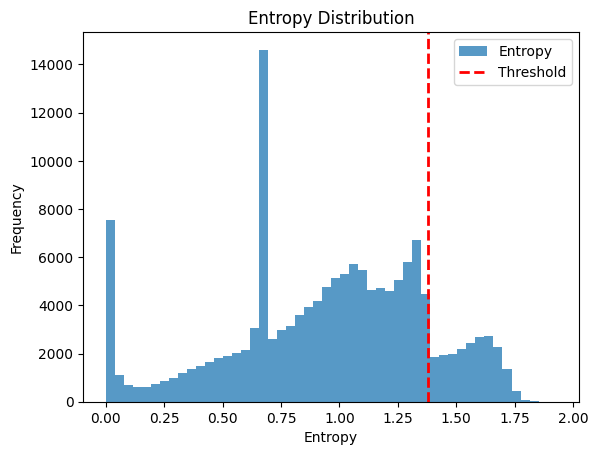

分界值: 1.377476480552272


In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 提取熵值
entropy = result_df['Entropy']

# 计算熵的均值和标准差
entropy_mean = entropy.mean()
entropy_std = entropy.std()
entropy_threshold = entropy_mean + entropy_std

# 绘制熵的分布图
plt.hist(entropy, bins=50, alpha=0.75, label='Entropy')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.title('Entropy Distribution')
plt.axvline(entropy_threshold, color='r', linestyle='dashed', linewidth=2, label='Threshold')
plt.legend()
plt.show()

# 可信的预测结果
reliable_predictions = result_df[entropy <= entropy_threshold]

# 输出结果
print(f"分界值: {entropy_threshold}")


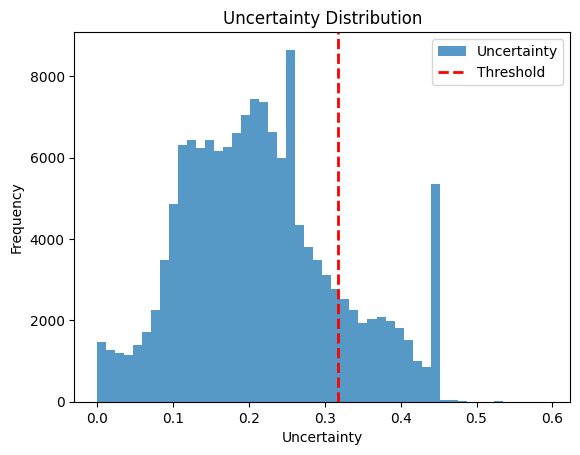

不确定性分界值: 0.31763485669342584


In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
uncertainty = result_df['Uncertainty']
# 计算不确定性的均值和标准差
uncertainty_mean = uncertainty.mean()
uncertainty_std = uncertainty.std()
uncertainty_threshold = uncertainty_mean + uncertainty_std

# 绘制不确定性的分布图
plt.hist(uncertainty, bins=50, alpha=0.75, label='Uncertainty')
plt.xlabel('Uncertainty')
plt.ylabel('Frequency')
plt.title('Uncertainty Distribution')
plt.axvline(uncertainty_threshold, color='r', linestyle='dashed', linewidth=2, label='Threshold')
plt.legend()
plt.show()

# 可信的预测结果
reliable_predictions = result_df[uncertainty <= uncertainty_threshold]

# 输出结果
print(f"不确定性分界值: {uncertainty_threshold}")


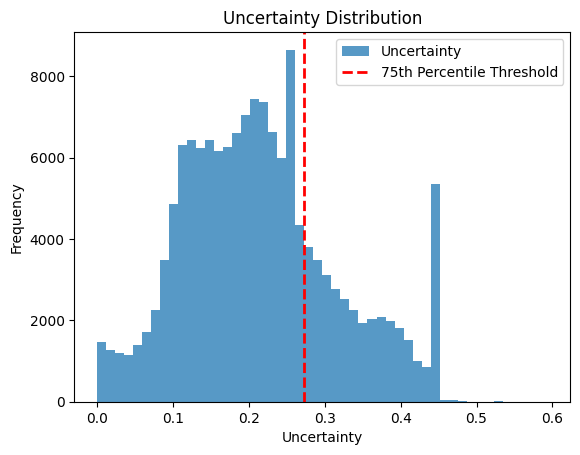

第75百分位数分界值: 0.27277571707963943


In [102]:
# 计算第75百分位数
uncertainty_threshold_75 = np.percentile(uncertainty, 75)

# 绘制不确定性的分布图
plt.hist(uncertainty, bins=50, alpha=0.75, label='Uncertainty')
plt.xlabel('Uncertainty')
plt.ylabel('Frequency')
plt.title('Uncertainty Distribution')
plt.axvline(uncertainty_threshold_75, color='r', linestyle='dashed', linewidth=2, label='75th Percentile Threshold')
plt.legend()
plt.show()

# 可信的预测结果
reliable_predictions_75 = result_df[uncertainty <= uncertainty_threshold_75]

# 输出结果
print(f"第75百分位数分界值: {uncertainty_threshold_75}")